This notebook is aimed at looked at the allele analysis output a bit more interms of what are the alleles. What is missing? What is the GO term enrichment in those if any? How much are effectors?....
The input is based on the following ideas:


the idea is to label alleles, non_allelic 'orthologs' singeltons, and single nuclear genes.
* alleles are bast on proteinortho -synteny flag
* non_allelic 'orthologs' are genes that cluster on the protein level but are not allelic
* singeltons are genes without ‘ortholog’ in the other haplotype
* single haplotype genes are genes that have no gene to genome blast hit e_value = 1e-2 and are not in a homozygous region.

Final analysis is based on Pst_104E_v12_missing_allele_QC_v03.ipynb and Pst_104E_v12_defining_alleles_v03.ipynb in folder 
/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/allele_analysis/no_alleles_proteinortho_graph516_QC_Qcov80_PctID70_evalue01 and alleles_proteinortho_graph516


In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import os
import re
from Bio import SeqIO
from Bio import SeqUtils
import pysam
from Bio.SeqRecord import SeqRecord
from pybedtools import BedTool
import numpy as np
import pybedtools
import time
import matplotlib.pyplot as plt
import sys
import subprocess
import shutil
from Bio.Seq import Seq
import pysam
from Bio import SearchIO
import json
import glob
import scipy.stats as stats
import statsmodels as sms
import statsmodels.sandbox.stats.multicomp
import distance
import seaborn as sns

/home/benjamin/anaconda3/lib/python3.5/site-packages/Bio/SearchIO/__init__.py:211: BiopythonExperimentalWarning: Bio.SearchIO is an experimental submodule which may undergo significant changes prior to its future official release.
  BiopythonExperimentalWarning)


In [3]:
pwh_set = []
def pwh_filter (q_contig, pwh_set=pwh_set):
    '''Checks if contig belongs to the primary with haplotig set.'''
    if q_contig in pwh_set:
        return True
    else:
        return False

In [4]:
def on_primary_contig (q_contig):
    '''Quick function that checks if query is on primary contig or not'''
    if q_contig.startswith('hcontig'):
        return False
    elif q_contig.startswith('pcontig'):
        return True
    else:
        print('Contig annotation needs to start with hcontig or pcontig')

In [5]:
###make a function out of the 5' and 3' prime distance
def _5_to_3_df(ref_bed_fn, query_bed_fn, io=False ):
    """Takes two bed6 filenames and returns dataframe with 5' and 3' distances."""
    from pybedtools import BedTool
    ref = BedTool(ref_bed_fn)
    query = BedTool(query_bed_fn)

    sub_3 = ref.closest(query ,io=io,  N=True, iu=True, D='a' ).to_dataframe()
    sub_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, \
                 inplace=True)
    sub_5 = ref.closest(query,\
                                io=io,N=True, id=True, D='a' ).to_dataframe()
    sub_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)

    #merging them
    sub_merged = sub_3.merge(sub_5, on=['query', 'contig'])

    #needs to be fixed to take boundaries into account
    #remove genes on the edges
    sub_merged = sub_merged [((sub_merged['5_target'] != '.') & (sub_merged['3_target'] != '.') )  ]
    sub_merged['5_distance'] = sub_merged['5_distance'].apply(lambda x: np.absolute(x))
    return sub_merged

In [6]:
#define a function that subsets a dataframe to the inner quantil residual columnwise
def quant_cut_df(dataframe):
    nn_df = dataframe.copy()
    iqr_df_low = nn_df.apply(lambda x: x.quantile(0.25) - 1.5*(x.quantile(0.75) - x.quantile(0.25)) )
    iqr_df_low.name ='low'
    iqr_df_high = nn_df.apply(lambda x: x.quantile(0.75) + 1.5*(x.quantile(0.75) - x.quantile(0.25)) )
    iqr_df_high.name = 'high'

    iqr_df = pd.concat([iqr_df_low, iqr_df_high], axis=1).T

    iqr_nn_df = nn_df.apply(lambda x: x[(x > iqr_df.loc['low', x.name]) & (x  < iqr_df.loc['high', x.name])], axis=0)
    return iqr_nn_df 


# After restart get started here.

In [7]:
#Define the PATH
BASE_AA_PATH = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12'
BASE_A_PATH = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/032017_assembly'
BLAST_RESULT_PATH = os.path.join(BASE_AA_PATH,'allele_analysis' )
ALLELE_PATH =os.path.join(BASE_AA_PATH ,'allele_analysis/alleles_proteinortho_graph516')
ALLELE_QC_PATH = os.path.join(BASE_AA_PATH, 'allele_analysis', \
                              'no_alleles_proteinortho_graph516_QC_Qcov80_PctID70_evalue01')
LIST_PATH = os.path.join(BASE_AA_PATH, 'enrichment_analysis', 'lists')
POST_ALLELE_PATH = os.path.join(BASE_AA_PATH, 'post_allele_analysis')
OUT_PATH = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/revision/allelic_variation'
OUT_FOLDER_FIG = OUT_PATH
if not os.path.exists(POST_ALLELE_PATH):
    os.mkdir(POST_ALLELE_PATH)
if not os.path.exists(OUT_PATH):
    os.mkdir(OUT_PATH)
ph_gene_fasta = os.path.join(BASE_A_PATH , 'Pst_104E_v12_ph_ctg.anno.gene.fa')
ph_cds_fasta = os.path.join(BASE_A_PATH, 'Pst_104E_v12_ph_ctg.anno.CDS.fa')
ph_protein_fasta = os.path.join(BASE_A_PATH, 'Pst_104E_v12_ph_ctg.anno.protein.fa')
IN_PATH = os.path.join(POST_ALLELE_PATH, 'proteinortho_graph516_QC_Qcov80_PctID70_evalue01')

In [20]:
#now read in some types of genes
gene_group_list = ['BUSCOS', 'EFFECTORS', 'HAUSTORIA', 'EFFECTORP']
p_gene_dict = {}
h_gene_dict = {}
p_gene_dict['BUSCOS'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_p_busco.list')\
                                    , header=None)[0].tolist()
p_gene_dict['EFFECTORS'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_p_effector.list')\
                                    , header=None)[0].tolist()
p_gene_dict['HAUSTORIA'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_cluster_8.list')\
                                    , header=None)[0].tolist()
p_gene_dict['EFFECTORP'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_p_effectorp.list')\
                                    , header=None)[0].tolist()
p_gene_dict['SIGNALP3'] = pd.read_csv(os.path.join(LIST_PATH, '..', 'pa_26062017',\
                            'Pst_104E_v12_p_ctg.SignalP3.tablist'), header=None, sep='\t')[0].tolist()

h_gene_dict['BUSCOS'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_h_busco.list')\
                                    , header=None)[0].tolist()
h_gene_dict['EFFECTORS'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_h_effector.list')\
                                    , header=None)[0].tolist()
h_gene_dict['HAUSTORIA'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_h_cluster_15.list')\
                                    , header=None)[0].tolist()
h_gene_dict['EFFECTORP'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_h_effectorp.list')\
                                    , header=None)[0].tolist()
h_gene_dict['SIGNALP3'] = pd.read_csv(os.path.join(LIST_PATH, '..', 'pa_26062017',\
                            'Pst_104E_v12_h_ctg.SignalP3.tablist'), header=None, sep='\t')[0].tolist()

#now get pwh and pwoh
pwh_list = pd.read_csv(os.path.join(BASE_A_PATH, 'Pst_104E_v12_pwh.txt')\
                                , header=None)[0].tolist()
pwoh_list = pd.read_csv(os.path.join(BASE_A_PATH, 'Pst_104E_v12_pwoh.txt')\
                                , header=None)[0].tolist()

In [8]:
allele_df_fn = os.path.join(IN_PATH, 'Pst_104E_v12_p_ctg.all.alleles.df')
allele_df = pd.read_csv(allele_df_fn, sep='\t')

In [10]:
allele_df.head()

,p_gene,h_gene,Linkage,codmel_dN/dS,protein_hamming,cds_hamming,protein_levenshtein,cds_levenshtein,vn00_dN/dS,LWL85_dN/dS,LWL85m_dN/dS,LPB93_dN/dS,folder
0,evm.model.pcontig_000.10,evm.model.hcontig_000_031.5,h_contig_overlap,0.3985,0.300000,0.297917,0.300000,0.297917,0.443299,0.317073,0.517241,0.425287,evm.model.pcontig_000.10_evm.model.hcontig_000...
1,evm.model.pcontig_000.100,evm.model.hcontig_000_003.107,h_contig_overlap,0.3816,0.024957,0.022662,0.024957,0.022088,0.379032,0.364341,0.445455,0.465347,evm.model.pcontig_000.100_evm.model.hcontig_00...
2,evm.model.pcontig_000.101,evm.model.hcontig_000_003.108,h_contig_overlap,1.2695,0.110169,0.070621,0.110169,0.070621,1.408971,0.650298,0.971717,0.894180,evm.model.pcontig_000.101_evm.model.hcontig_00...
3,evm.model.pcontig_000.102,evm.model.hcontig_000_003.109,h_contig_overlap,0.1372,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,evm.model.pcontig_000.102_evm.model.hcontig_00...
4,evm.model.pcontig_000.103,evm.model.hcontig_000_003.110,h_contig_overlap,98.9998,0.095745,0.081560,0.095745,0.081560,NaN,NaN,NaN,NaN,evm.model.pcontig_000.103_evm.model.hcontig_00...


In [12]:
allele_hit_df = pd.read_csv(os.path.join(IN_PATH, 'Pst_104E_v12_p_ctg.all.alleles.hit.df'),\
                    sep='\t')

In [14]:
allele_hit_df.head()

,Query,Target,PctID,AlnLgth,NumMis,NumGap,StartQuery,StopQuery,StartTarget,StopTarget,...,LWL85_dN/dS,LWL85m_dN/dS,LPB93_dN/dS,P_EFFECTOR,P_BUSCO,H_EFFECTOR,H_BUSCO,P_OTHER_GENE,H_OTHER_GENE,protein/cds_levdist
0,evm.model.pcontig_000.100,evm.model.hcontig_000_003.107,99.21,1141.0,9.0,0.0,1.0,1141.0,1.0,1141.0,...,0.364341,0.445455,0.465347,False,False,False,False,True,True,1.129870
1,evm.model.pcontig_000.101,evm.model.hcontig_000_003.108,89.03,237.0,20.0,1.0,1.0,231.0,1.0,237.0,...,0.650298,0.971717,0.894180,False,False,False,False,True,True,1.560000
2,evm.model.pcontig_000.102,evm.model.hcontig_000_003.109,100.00,107.0,0.0,0.0,1.0,107.0,1.0,107.0,...,NaN,NaN,NaN,False,False,False,False,True,True,NaN
3,evm.model.pcontig_000.103,evm.model.hcontig_000_003.110,97.73,88.0,2.0,0.0,8.0,95.0,1.0,88.0,...,NaN,NaN,NaN,False,False,False,False,True,True,1.173913
4,evm.model.pcontig_000.104,evm.model.hcontig_000_003.111,98.53,68.0,1.0,0.0,1.0,68.0,1.0,68.0,...,NaN,NaN,NaN,False,False,False,False,True,True,3.000000


In [17]:
(allele_hit_df.Query.apply(lambda x: x in p_gene_dict['EFFECTORS'])).sum()

1214

In [18]:
allele_hit_df['P_EFFECTOR'] = allele_hit_df.Query.apply(lambda x: x in p_gene_dict['EFFECTORS'])
allele_hit_df['P_BUSCO'] =  allele_hit_df.Query.apply(lambda x: x in p_gene_dict['BUSCOS'])
allele_hit_df['H_EFFECTOR'] = allele_hit_df.Target.apply(lambda x: x in h_gene_dict['EFFECTORS'])
allele_hit_df['H_BUSCO'] =  allele_hit_df.Target.apply(lambda x: x in h_gene_dict['BUSCOS'])

In [21]:
allele_hit_df['P_OTHER_GENE'] =  ~(allele_hit_df.Query.isin(p_gene_dict['EFFECTORS'])|\
                allele_hit_df.Query.isin(p_gene_dict['BUSCOS']))
allele_hit_df['H_OTHER_GENE'] =  ~(allele_hit_df.Target.isin(h_gene_dict['EFFECTORS'])|\
                allele_hit_df.Target.isin(h_gene_dict['BUSCOS']))

In [22]:
allele_hit_df['protein/cds_levdist'] = allele_hit_df['protein_levenshtein'] /allele_hit_df['cds_levenshtein']

In [23]:
allele_hit_df.to_csv(os.path.join(OUT_PATH, 'Pst_104E_v12_p_ctg.all.alleles.hit.df')\
                     , index=None, sep='\t')

In [74]:
#make a classification column to enable better plotting
allele_hit_df['p_classification'] = 'None'
allele_hit_df.loc[allele_hit_df[allele_hit_df.P_EFFECTOR == True].index,'p_classification']\
                = "Candidate effector"
allele_hit_df.loc[allele_hit_df[allele_hit_df.P_BUSCO == True].index,'p_classification']\
                = "BUSCO"
allele_hit_df.loc[allele_hit_df[allele_hit_df.P_OTHER_GENE == True].index,'p_classification']\
                = "Other"

In [75]:
#make a classification column to enable better plotting
allele_hit_df['h_classification'] = 'None'
allele_hit_df.loc[allele_hit_df[allele_hit_df.H_EFFECTOR == True].index,'h_classification']\
                = "Candidate effector"
allele_hit_df.loc[allele_hit_df[allele_hit_df.H_BUSCO == True].index,'h_classification']\
                = "BUSCO"
allele_hit_df.loc[allele_hit_df[allele_hit_df.H_OTHER_GENE == True].index,'h_classification']\
                = "Other"


Plot the variation of levenstain distances according to classification

In [27]:
allele_hit_df.columns

Index(['Query', 'Target', 'PctID', 'AlnLgth', 'NumMis', 'NumGap', 'StartQuery',
       'StopQuery', 'StartTarget', 'StopTarget', 'e-value', 'BitScore',
       'QLgth', 'QCov', 'q_contig', 't_contig', 'q_contig == t_contig',
       'p_protein', 'h_contig_overlap', 't_contig == h_contig_overlap',
       'folder', 'protein_hamming', 'cds_hamming', 'protein_levenshtein',
       'cds_levenshtein', 'vn00_dN/dS', 'LWL85_dN/dS', 'LWL85m_dN/dS',
       'LPB93_dN/dS', 'P_EFFECTOR', 'P_BUSCO', 'H_EFFECTOR', 'H_BUSCO',
       'P_OTHER_GENE', 'H_OTHER_GENE', 'protein/cds_levdist',
       'p_classification', 'h_classification'],
      dtype='object')

In [28]:
import matplotlib
#histogram of 
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
matplotlib.rc('font', **font)


In [78]:
df = allele_hit_df.loc[:,['PctID', "p_classification"]].copy()
df = df.pivot(values='PctID', columns= 'p_classification')
t_be, p_be = stats.ranksums(df['BUSCO'].dropna().values, df['Candidate effector'].dropna().values)
t_oe, p_oe = stats.ranksums(df['Other'].dropna().values, df['Candidate effector'].dropna().values)
t_ob, p_ob = stats.ranksums(df['BUSCO'].dropna().values, df['Other'].dropna().values)
print(statsmodels.sandbox.stats.multicomp.multipletests([p_be, p_oe,p_ob],\
    alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False))
df.describe()

(array([ True,  True,  True], dtype=bool), array([  6.39739834e-03,   2.91801817e-03,   1.20897095e-17]), 0.016952427508441503, 0.016666666666666666)


p_classification,BUSCO,Candidate effector,Other
count,1198.000000,1214.000000,8509.000000
mean,98.931144,97.459423,97.335696
std,4.133346,6.268232,7.224012
min,21.980000,31.430000,22.650000
25%,99.050000,97.670000,98.080000
50%,99.770000,99.685000,99.500000
75%,100.000000,100.000000,100.000000
max,100.000000,100.000000,100.000000


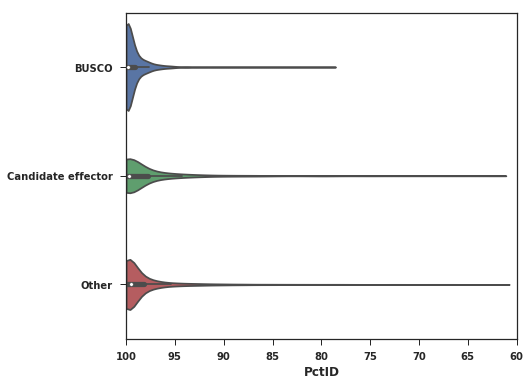

In [113]:
sns.set(style="ticks")

column_to_plot = 'PctID'

# Initialize the figure with a logarithmic x axis
df = allele_hit_df.loc[:,[column_to_plot, "p_classification"]].fillna(0).copy()
#qdf = quant_cut_df(df.pivot(values='protein/cds_levdist', columns= 'p_classification'))

sns.set_style("ticks")

pallete = sns.color_palette('colorblind')
ax.xaxis.grid(True)
sns.despine(trim=True, left=True)

f, ax = plt.subplots(figsize=(7, 6))
df = df[df.PctID >= df.PctID.quantile(0.01)]
#ax.set_xscale("log")
sns.violinplot(x=column_to_plot, y="p_classification", data=df.sort_values("p_classification"), cut=0,
          whis=np.inf, color_palette= pallete)
plt.setp(ax.artists, alpha=.01)
plt.ylabel("")
plt.xlabel(column_to_plot, size=12, weight= 'bold')
plt.xlim(100,60)
fn = os.path.join(OUT_PATH, '%s_variation.png'%column_to_plot)
f.savefig(fn, dp=600)

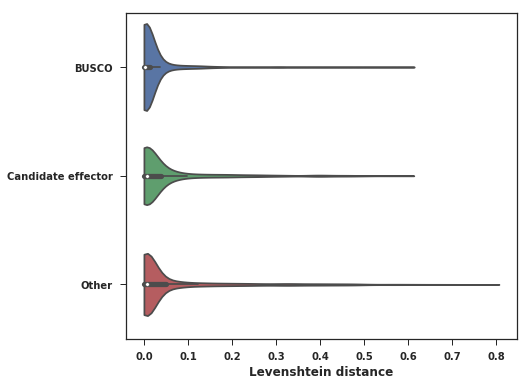

In [92]:
sns.set(style="ticks")

column_to_plot = 'protein_levenshtein'

# Initialize the figure with a logarithmic x axis
df = allele_hit_df.loc[:,[column_to_plot, "p_classification"]].fillna(0).copy()
#qdf = quant_cut_df(df.pivot(values='protein/cds_levdist', columns= 'p_classification'))

sns.set_style("ticks")

pallete = sns.color_palette('colorblind')
ax.xaxis.grid(True)
sns.despine(trim=True, left=True)

f, ax = plt.subplots(figsize=(7, 6))
df = df[df[column_to_plot] >= df[column_to_plot].quantile(0.01)]
#ax.set_xscale("log")
sns.violinplot(x=column_to_plot, y="p_classification", data=df.sort_values("p_classification"), cut=0,
          whis=np.inf, color_palette= pallete)
plt.setp(ax.artists, alpha=.01)
plt.ylabel("")
plt.xlabel("Levenshtein distance", size=12, weight= 'bold')

fn = os.path.join(OUT_PATH, '%s_variation.png'%column_to_plot)
f.savefig(fn, dp=600)

In [87]:
df = allele_hit_df.loc[:,['protein_levenshtein', "p_classification"]].copy()
df = df.pivot(values='protein_levenshtein', columns= 'p_classification')
t_be, p_be = stats.ranksums(df['BUSCO'].dropna().values, df['Candidate effector'].dropna().values)
t_oe, p_oe = stats.ranksums(df['Other'].dropna().values, df['Candidate effector'].dropna().values)
t_ob, p_ob = stats.ranksums(df['BUSCO'].dropna().values, df['Other'].dropna().values)
print(statsmodels.sandbox.stats.multicomp.multipletests([p_be, p_oe,p_ob],\
    alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False))
df.describe()

(array([ True,  True,  True], dtype=bool), array([  1.41936205e-04,   2.79132809e-05,   1.31692407e-25]), 0.016952427508441503, 0.016666666666666666)


p_classification,BUSCO,Candidate effector,Other
count,1198.000000,1214.000000,8509.000000
mean,0.026463,0.047405,0.063723
std,0.072211,0.095963,0.126181
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.002817,0.006006,0.007576
75%,0.014429,0.039832,0.049505
max,0.613811,0.612782,0.806084


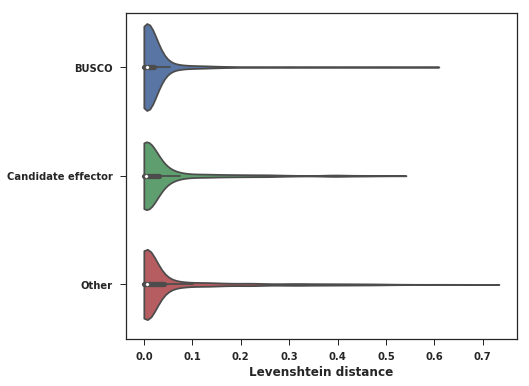

In [91]:
sns.set(style="ticks")

column_to_plot = 'cds_levenshtein'

# Initialize the figure with a logarithmic x axis
df = allele_hit_df.loc[:,[column_to_plot, "p_classification"]].fillna(0).copy()
#qdf = quant_cut_df(df.pivot(values='protein/cds_levdist', columns= 'p_classification'))

sns.set_style("ticks")

pallete = sns.color_palette('colorblind')
ax.xaxis.grid(True)
sns.despine(trim=True, left=True)

f, ax = plt.subplots(figsize=(7, 6))
df = df[df[column_to_plot] >= df[column_to_plot].quantile(0.01)]
#ax.set_xscale("log")
sns.violinplot(x=column_to_plot, y="p_classification", data=df.sort_values("p_classification"), cut=0,
          whis=np.inf, color_palette= pallete)
plt.setp(ax.artists, alpha=.01)
plt.ylabel("")
plt.xlabel("Levenshtein distance", size=12, weight= 'bold')

fn = os.path.join(OUT_PATH, '%s_variation.png'%column_to_plot)
f.savefig(fn, dp=600)

In [90]:
df = allele_hit_df.loc[:,['cds_levenshtein', "p_classification"]].copy()
df = df.pivot(values='cds_levenshtein', columns= 'p_classification')
t_be, p_be = stats.ranksums(df['BUSCO'].dropna().values, df['Candidate effector'].dropna().values)
t_oe, p_oe = stats.ranksums(df['Other'].dropna().values, df['Candidate effector'].dropna().values)
t_ob, p_ob = stats.ranksums(df['BUSCO'].dropna().values, df['Other'].dropna().values)
print(statsmodels.sandbox.stats.multicomp.multipletests([p_be, p_oe,p_ob],\
    alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False))
df.describe()

(array([False,  True,  True], dtype=bool), array([  1.42036020e-01,   1.81420068e-10,   5.36745556e-05]), 0.016952427508441503, 0.016666666666666666)


p_classification,BUSCO,Candidate effector,Other
count,1198.000000,1214.000000,8509.000000
mean,0.028763,0.040684,0.057879
std,0.070337,0.087243,0.115095
min,0.000000,0.000000,0.000000
25%,0.000642,0.000000,0.000734
50%,0.006682,0.004444,0.007407
75%,0.021833,0.031040,0.040936
max,0.609335,0.541353,0.733333


In [93]:
allele_hit_df.columns

Index(['Query', 'Target', 'PctID', 'AlnLgth', 'NumMis', 'NumGap', 'StartQuery',
       'StopQuery', 'StartTarget', 'StopTarget', 'e-value', 'BitScore',
       'QLgth', 'QCov', 'q_contig', 't_contig', 'q_contig == t_contig',
       'p_protein', 'h_contig_overlap', 't_contig == h_contig_overlap',
       'folder', 'protein_hamming', 'cds_hamming', 'protein_levenshtein',
       'cds_levenshtein', 'vn00_dN/dS', 'LWL85_dN/dS', 'LWL85m_dN/dS',
       'LPB93_dN/dS', 'P_EFFECTOR', 'P_BUSCO', 'H_EFFECTOR', 'H_BUSCO',
       'P_OTHER_GENE', 'H_OTHER_GENE', 'protein/cds_levdist',
       'p_classification', 'h_classification'],
      dtype='object')

In [102]:
out_df = allele_hit_df.loc[:,['Query', 'Target', 'cds_levenshtein', 'protein_levenshtein','PctID',\
                               'p_classification', 'h_classification']].copy()

In [106]:
rename_dict = dict(zip(out_df.columns,['Primary protein ID', 'Haplotig protein ID',\
                         'CDS Levenshtein distance','CDS Levenshtein distance', \
                         'Blastp PctID',\
                         'Primary protein classification', \
                         'Haplotig protein classification' ]))

In [108]:
out_df.rename(columns=rename_dict, inplace=True)

In [109]:
out_fn = os.path.join(OUT_PATH, 'Pst_104E_allele_variation.df')

In [110]:
out_df.to_csv(out_fn, sep='\t', index=None)